## The North Face e-commerce : boosting online sales !

### Librairies and imports

In [1]:
# Install spacy 
## -q is for "quiet". It removes logs 
!pip install spacy -q 

In [1]:
import spacy
import re
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go

In [2]:
# Download english model 
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Import English using en_core_web_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

### Preprocessing of textual data

In [34]:
df = pd.read_csv("src/north_face_product_catalalog.csv")
print("Number of rows:", df.shape[0])
display(df.head())

Number of rows: 500


id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [35]:
print(df["description"][1])
print(df["description"][5])
print(df["description"][25])
print(df["description"][100])

Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Progr

In [36]:
# Modify column description with the all sentence before "Recyclable through the Common Threads Recycling Program."
df["description"] = [x.split("Recyclable through the Common Threads Recycling Program")[0] for x in df["description"]]
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [37]:
print(df["description"][1])
print(df["description"][5])
print(df["description"][25])
print(df["description"][100])

Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. 
Ascensionist jkt - Our most technical soft shell for full-on mountain pursuits strikes the alpinist's balance between protection and minimalism. The dense 2-way-stretch polyester double weave, with stitchless seams, has exceptional water- and wind-resistance, a rapid dry time and superb breathability. Pared-down detailing provides everything you need and nothing more: a 3-way-adjustable, helmet-compatible hood; a reverse-coil center-front zipper with a DWR (durable water repellent) finish; large external handwarmer 

In [38]:
# Remove html elements 
df["clean_description"] = df["description"].apply(lambda x: re.sub("<[^<]+?>","",x))

# Remove ponctuation
df["clean_description"] = df["clean_description"].apply(lambda x: re.sub('[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+'," ", x)) 

# Keep only alpha numeric
df["clean_description"] = df["clean_description"].apply(lambda x: re.sub("[^0-9a-zA-Z]+", " ", x)) # replace all non alphanumerical char by a space

# Remove uppercase
df["clean_description"] = df["clean_description"].fillna('').apply(lambda x: x.lower())

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  
0  active classic boxers there s a reason why our...  
1  active sport boxer briefs skinning up glory re...  
2  active sport briefs these superbreathable no f...  
3  alpine guide pants skin in climb ice switch to...  
4  alpine wind jkt on high ridges steep ice and a...

In [39]:
from spacy.lang.en.stop_words import STOP_WORDS

# Tokenization
df["desc_tokenized"] = df["clean_description"].fillna("").apply(lambda x: nlp(x))

# Remove stop words
df["desc_tokenized"] = df["desc_tokenized"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  
0  [active, classic, boxer, s, reason, boxer, cul...  
1  [active, sport, boxer, brief, skin, glory, req...  
2  [active, sport, brief, superbreathable, fly, b...  
3  [alpine, guide, pant, skin, climb, ice, switch...  
4  [alpine, wind, jkt, high, ridge, steep, ice, a...

In [40]:
# Detokenization : join every token of the list into a single string separated by a space
df["nlp_ready"] = df["desc_tokenized"].apply(lambda x: " ".join(x))

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  \
0  [active, classic, boxer, s, reason, boxer, cul...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, fly, b...   
3  [alpine, guide, pant, skin, climb, ice, switch...   
4  [alpine, wind, jkt, high, ridge, steep, ice, a...   

                                           nlp_ready  
0  active classic boxer s reason boxer cult favor...  
1  active sport boxer brief skin glory require mo...  
2  active sport brief superbreathable fly brief m...  
3  alpine guide pant skin climb ice switch rock t...  
4  alpine wind jkt high ridge steep ice alpine ja...

In [41]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["nlp_ready"])
X_dense  = X.toarray()
X_dense 

array([[0.        , 0.        , 0.05905857, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.10368055, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05383735, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07158753, ..., 0.        , 0.        ,
        0.        ]])

### Part 1 : Groups of products with similar descriptions

In [43]:
# Compute cosine distance between samples in X and Y
distances = pairwise_distances(X, metric="cosine")

# Parameters
eps = 0.75
min_samples = 5

# Instanciate DBscan
db = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
db.fit(distances)

# Count the number of unique labels
num_clusters = len(np.unique(db.labels_))

# Output the resulting clusters
print("Number of clusters:", num_clusters)
print("")
print("Cluster labels: \n", db.labels_)

unique_labels, label_counts = np.unique(db.labels_[db.labels_ == -1], return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print("")
    print("Outliers label:", label)
    print("Number of outliers:", count)

Number of clusters: 17

Cluster labels: 
 [ 0  0  0  1  1  1  1  2 -1  4 -1  3  4 -1  1  1  4  5  0  5  5  5  5  5
  5  6  1  1  1 13  1  1  1 -1  1  6  1 -1 -1 -1  6  1  1  1 -1 -1 -1  7
  1  1  1 -1  1  1  1  6 -1  6  1  5  5 -1  6  6  6 -1  1  6  7 -1  6  6
  6  4  8 -1  8 -1  9  9  9 15  1  1  1  1 10 10 10 10  1 13  1  1  6  1
  1  6 -1 13 -1  6  6  1 15 15  1  1  1  1 -1 -1 11 11  1  6 12  1  1  1
 -1 -1 -1  6 -1 -1 -1 -1  1  1  1 -1  1  1  4 11 -1  6  6 -1  1 -1  1  6
 -1 13  1  9  4  1 -1  6  1  1 -1  2 -1 -1  1 -1 -1 14  1 -1 -1 -1  6  1
  6  6  5  5  5  5  5  5  6  6  1 -1 -1 -1 -1  1  6  1  1  1  1  1  1  1
  1  1  8 12  1 -1 -1 10 10 10 10  1  1 -1  1  1  1  1 -1  1  1  1  1  1
  1 -1  2  2  2  2  1  1 -1  8 -1 -1 -1 -1  1  1  2  1  1 -1  6  7  6  2
  2  2  2  2 12  1  1 14 14 -1  6  2  2  2  2  1 -1  2 13 10  2  2 15 15
 10 10  1  1 10 10  1  1  1  1  1  6  5  1 -1  1  1  1 -1  1 -1  6 -1  6
  6 -1  2 -1  1  1 -1 -1 14 14 -1  0  2  1  1  1  1  1  1  1 -1 14 14  3
  1  1  6

In [44]:
labels = db.labels_

# Add clusters to the dataset
df["cluster"] = labels
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  \
0  [active, classic, boxer, s, reason, boxer, cul...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, fly, b...   
3  [alpine, guide, pant, skin, climb, ice, switch...   
4  [alpine, wind, jkt, high, ridge, steep, ice, a...   

                                           nlp_ready  cluster  
0  active classic boxer s reason boxer cult favor...        0  
1  active sport boxer brief skin glory require mo...        0  
2  active sport brief superbreathable fly brief m...        0  
3  alpine guide pant skin climb ice switch rock t...        1  
4  alpine wind jkt high ridge steep ice alpine ja...        1

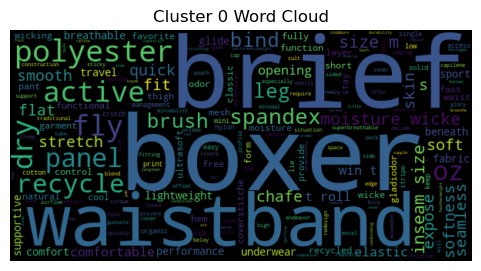

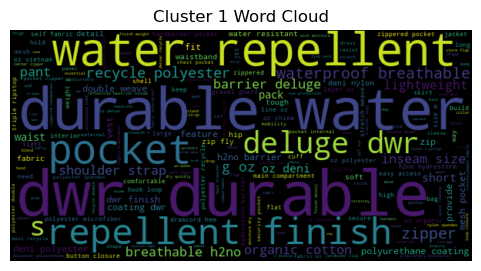

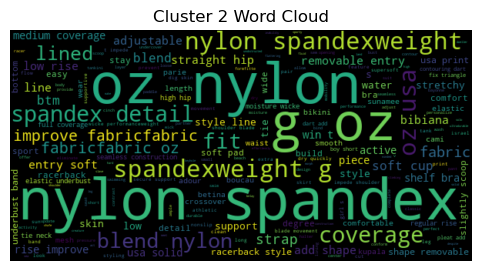

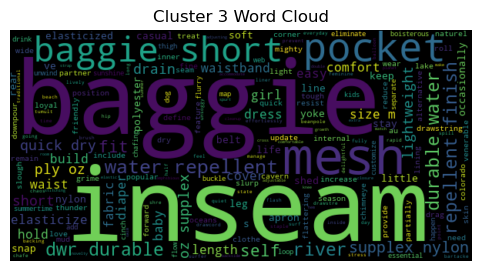

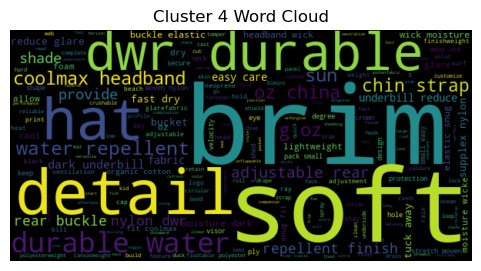

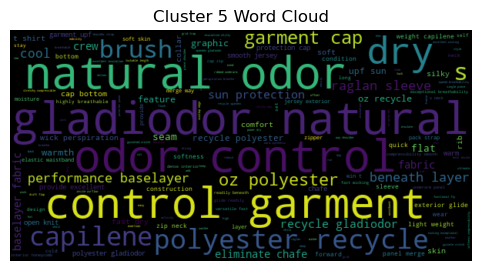

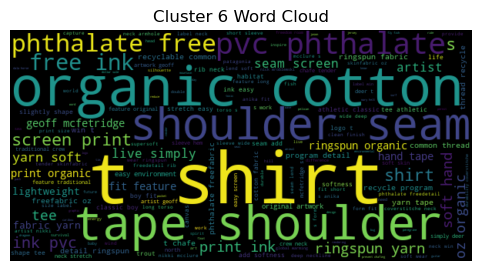

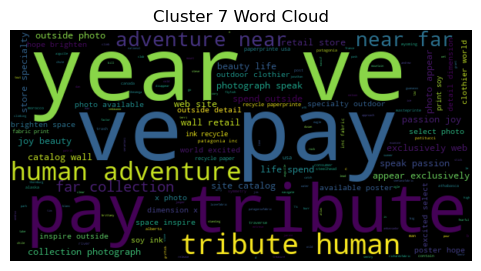

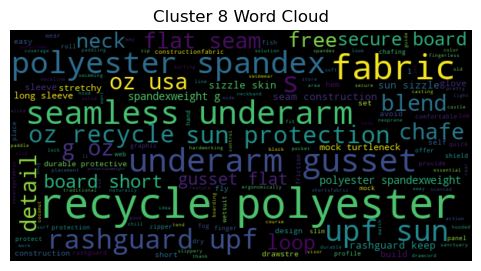

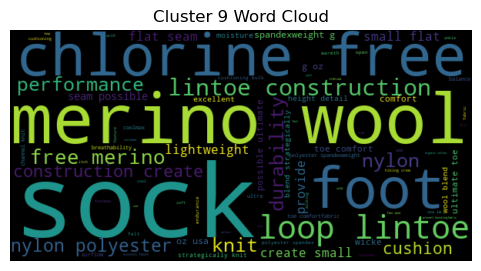

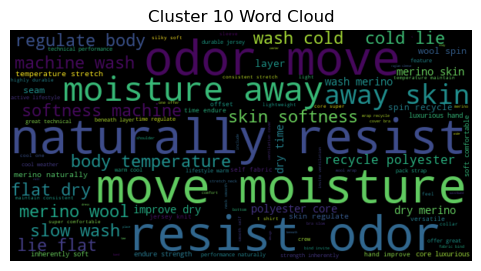

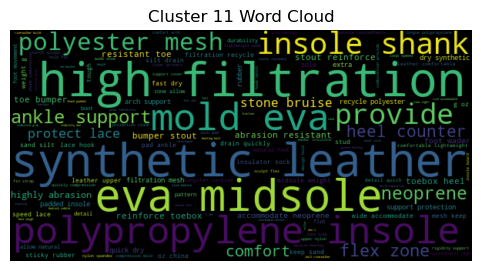

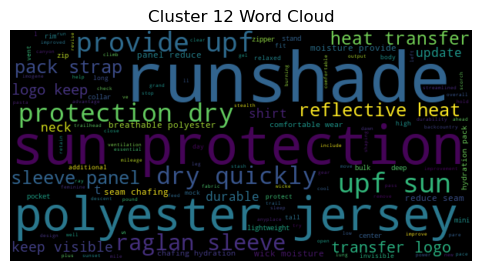

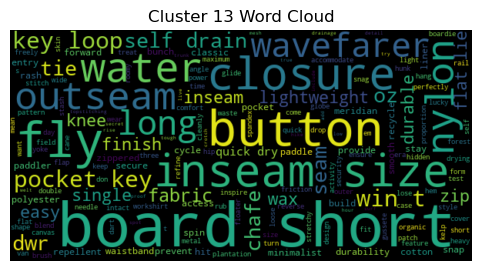

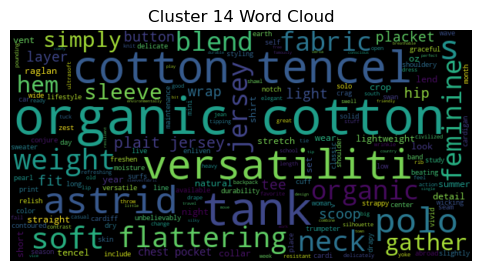

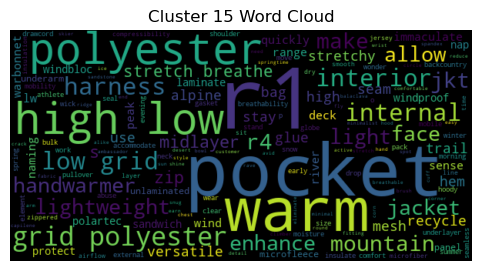

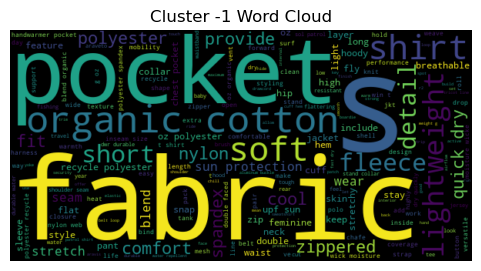

In [45]:
import wordcloud
from wordcloud import WordCloud

# Loop over each cluster
for cluster_id in set(labels):
    # Filter the documents belonging to the current cluster
    cluster_documents = df[df["cluster"] == cluster_id]["nlp_ready"]
    
    # Concatenate all the documents into a single string
    cluster_text = " ".join(cluster_documents)
    
    # Generate a word cloud for the cluster
    wordcloud = WordCloud(width=600, height=300).generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Word Cloud')
    plt.show()

### Part 2 - Recommender system

In [46]:
def find_similar_items(item_id):
    # Get the cluster ID of the given item
    mask1 = df["id"] == item_id
    item_cluster = df.loc[mask1, "cluster"].values[0]

    # Get all items belonging to the same cluster
    mask2 = df["cluster"] == item_cluster
    cluster_items = df.loc[mask2, "id"]

    # Remove the given item from the list of cluster items
    cluster_items = cluster_items.loc[cluster_items != item_id]

    # Return a list of similar items
    similar_items = cluster_items.sample(n=5, random_state=42).tolist()
    return similar_items

In [57]:
# Take user input for the item ID
user_item_id = input("Enter the item ID you're interested in: ")

# Display the recommendations
print("You choose article", user_item_id, ", we recommand you these similar items:", find_similar_items(int(user_item_id)))

You choose article 5 , we recommand you these similar items: [216, 49, 193, 328, 214]


In [58]:
df[df['id'].isin( [5, 216, 49, 193, 328, 214])]

id                                        description  \
4      5  Alpine wind jkt - On high ridges, steep ice an...   
48    49  Great divider - From standing waves to blue-wa...   
192  193  Lithia pants - Pull out the Lithia Pants after...   
213  214  Rock guide shorts - Tough, abrasion-resistant ...   
215  216  Simple guide jkt - Skin-in by headlamp, summit...   
327  328  Borderless pants - The Borderless Pants won't ...   

                                     clean_description  \
4    alpine wind jkt on high ridges steep ice and a...   
48   great divider from standing waves to blue wate...   
192  lithia pants pull out the lithia pants after y...   
213  rock guide shorts tough abrasion resistant roc...   
215  simple guide jkt skin in by headlamp summit by...   
327  borderless pants the borderless pants won t he...   

                                        desc_tokenized  \
4    [alpine, wind, jkt, high, ridge, steep, ice, a...   
48   [great, divider, stand, wave, blue, water, win...   
192  [lithia, pant, pull, lithia, pant, ve, get, da...   
213  [rock, guide, short, tough, abrasion, resistan...   
215  [simple, guide, jkt, skin, headlamp, summit, n...   
327  [borderless, pant, borderless, pant, win, t, h...   

                                             nlp_ready  cluster  
4    alpine wind jkt high ridge steep ice alpine ja...        1  
48   great divider stand wave blue water wind chop ...        1  
192  lithia pant pull lithia pant ve get daily wave...        1  
213  rock guide short tough abrasion resistant rock...        1  
215  simple guide jkt skin headlamp summit noon fin...        1  
327  borderless pant borderless pant win t hem ques...        1

### Part 3 : Topic modeling

In [59]:
# Use the TruncatedSVD model in order to create a topic model with 20 different topics
svd_model = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
lsa = svd_model.fit_transform(X)

col_names = []
for x in range(1, 21) :
    c = "topic_" + str(x)
    col_names.append(c)
    x+=1

topic_encoded_df = pd.DataFrame(lsa, columns = col_names)
topic_encoded_df["text"] = df["nlp_ready"]
topic_encoded_df

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0    0.180611  0.024575  0.113267  0.056220 -0.020723 -0.075348  0.025130   
1    0.184521  0.016711  0.107042  0.077481  0.010539 -0.067948 -0.045117   
2    0.181476 -0.025303  0.085678  0.023512  0.052596 -0.071981 -0.000917   
3    0.274350 -0.121598 -0.042244  0.008048 -0.070364  0.042715 -0.071226   
4    0.280778 -0.133267 -0.020498 -0.109318 -0.005791 -0.055496 -0.072814   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.255432  0.006266  0.253975 -0.011347 -0.014386 -0.317450 -0.110492   
496  0.299619  0.031531  0.321410 -0.114636  0.018220 -0.331005 -0.071493   
497  0.278708 -0.144060 -0.042039 -0.127340 -0.018118  0.041265 -0.121861   
498  0.190630  0.066322  0.006094  0.234000 -0.148699  0.002498  0.049942   
499  0.227764  0.064134 -0.027948  0.268298 -0.173125  0.023247  0.060758   

      topic_8   topic_9  topic_10  ...  topic_12  topic_13  topic_14  \
0    0.008124  0.029883 -0.030598  ... -0.083516 -0.003148 -0.016486   
1   -0.014323  0.036882  0.032120  ... -0.173740 -0.076819  0.031892   
2   -0.011422  0.088187 -0.008202  ... -0.130328 -0.037304  0.058494   
3   -0.002734 -0.129243  0.114301  ... -0.278256 -0.048772 -0.072055   
4    0.010486 -0.219534  0.138579  ... -0.055436  0.106663  0.032859   
..        ...       ...       ...  ...       ...       ...       ...   
495 -0.001071  0.008602 -0.157339  ... -0.167694  0.043672 -0.109567   
496  0.001514 -0.037191 -0.146758  ... -0.039414  0.055872 -0.005456   
497  0.011097 -0.034544 -0.023927  ...  0.061674  0.041000  0.014412   
498 -0.020531 -0.021014 -0.044171  ... -0.034859  0.098081  0.088296   
499 -0.024665 -0.049254 -0.027174  ... -0.001423  0.050335  0.064925   

     topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  \
0    0.040667  0.104265 -0.053570  0.040347 -0.084721 -0.117104   
1    0.014841  0.061209 -0.078794  0.043177 -0.088351 -0.154034   
2    0.001305 -0.037155 -0.014416  0.040961 -0.063295 -0.101854   
3    0.016515 -0.230023  0.006685 -0.035515 -0.115054  0.273553   
4    0.186951  0.023517  0.095794 -0.011455 -0.056860  0.034715   
..        ...       ...       ...       ...       ...       ...   
495  0.005831  0.102400 -0.040867  0.017278 -0.026838  0.073513   
496 -0.047514  0.086576 -0.052913  0.017992  0.011875  0.106711   
497  0.014666 -0.015107  0.015877  0.034698 -0.021492 -0.072410   
498  0.001570  0.026995  0.051439 -0.013304  0.207557 -0.142856   
499  0.047604  0.020241  0.036477  0.031566  0.062523 -0.135025   

                                                  text  
0    active classic boxer s reason boxer cult favor...  
1    active sport boxer brief skin glory require mo...  
2    active sport brief superbreathable fly brief m...  
3    alpine guide pant skin climb ice switch rock t...  
4    alpine wind jkt high ridge steep ice alpine ja...  
..                                                 ...  
495  cap 2 bottom cut loose madden crowd search und...  
496  cap 2 crew crew take edge fickle weather clear...  
497  time shell need use morning time umbrella time...  
498  wear cargo short wear cargo short bask glory s...  
499  wear short time simplify wear short prove shor...  

[500 rows x 21 columns]

In [60]:
# Assign each document to the topic it is the most linked to
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]
topic_encoded_df["class_pred"].value_counts()

0     256
1      68
3      29
10     27
2      24
4      22
6      21
16      9
12      9
7       8
8       7
9       5
13      4
18      4
15      3
17      3
11      1
Name: class_pred, dtype: int64

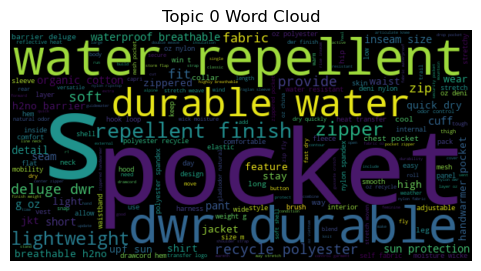

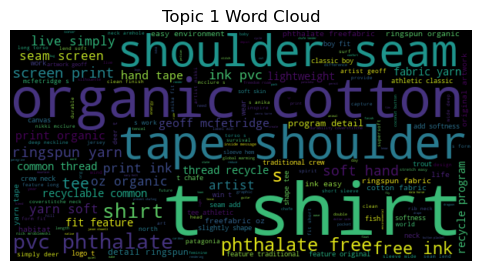

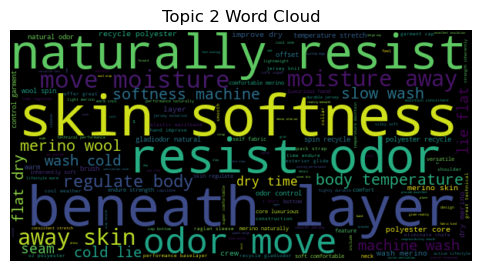

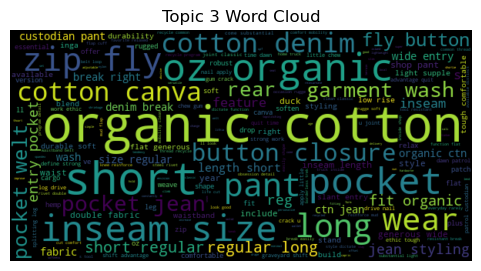

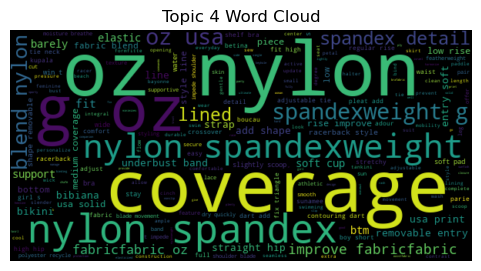

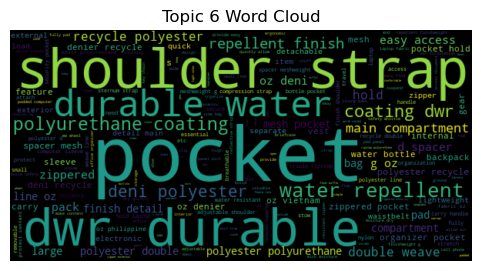

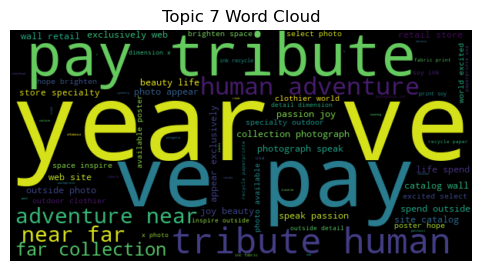

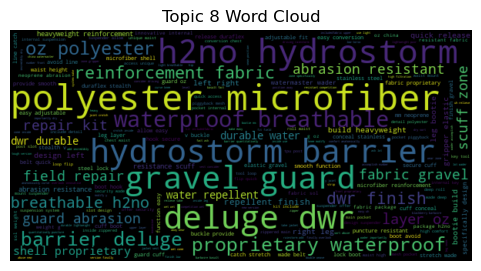

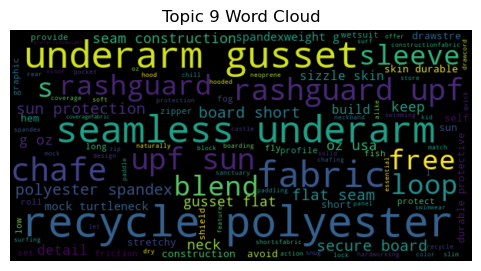

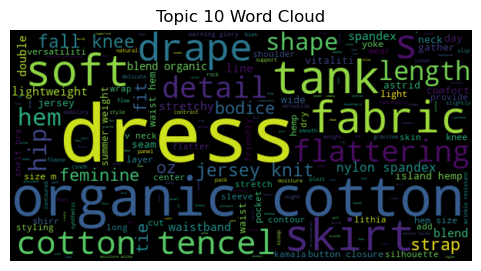

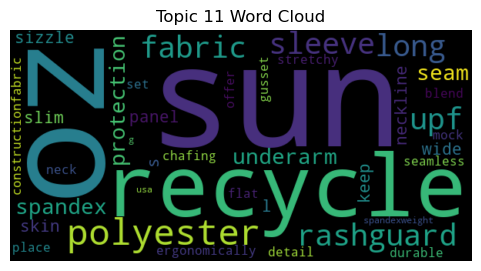

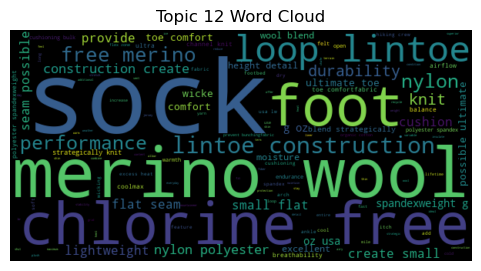

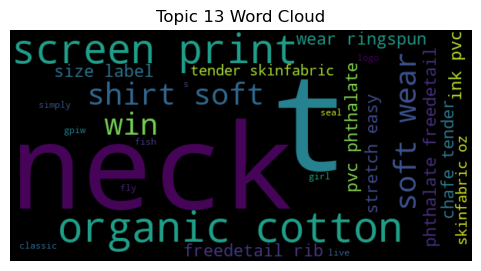

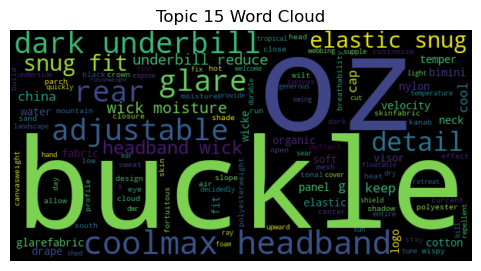

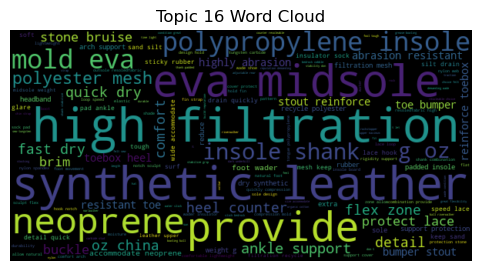

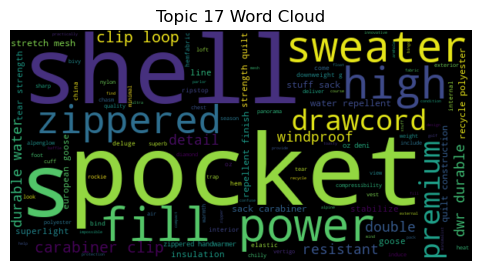

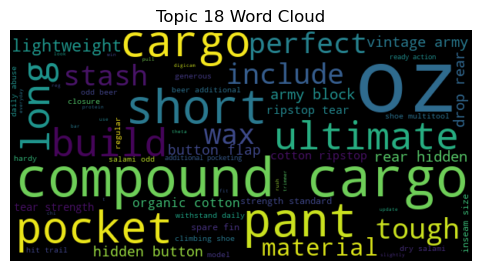

In [61]:
labels = topic_encoded_df["class_pred"]

# Loop over each topic
for topic_id in set(labels):
    # Filter the documents belonging to the current topic
    topic_documents = topic_encoded_df[topic_encoded_df["class_pred"] == topic_id]["text"]
    
    # Concatenate all the documents into a single string
    topic_text = " ".join(topic_documents)
    
    # Generate a word cloud for the topic
    wordcloud = WordCloud(width=600, height=300).generate(topic_text)
    
    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id} Word Cloud')
    plt.show()